<a href="https://colab.research.google.com/github/SammyKen18/SammyKen18/blob/main/Customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORT PACKAGES
#%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

In [ ]:
#DATA
customers = pd.read_csv("mall_customers.csv")
customers.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
print(customers.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
CustomerID                200 non-null int64
Genre                     200 non-null object
Age                       200 non-null int64
Annual Income (k$)        200 non-null int64
Spending Score (1-100)    200 non-null int64
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


In [ ]:
#DATA EXPLORATION
#Check for Null Values
missing_val_count_by_column = (customers.isnull().sum())
print("overall ", len(missing_val_count_by_column[missing_val_count_by_column > 0]) ,
      "variables with missing values" , "\nin details:","\n" , missing_val_count_by_column[missing_val_count_by_column > 0])


overall  0 variables with missing values 
in details: 
 Series([], dtype: int64)


In [ ]:
def statistics(variable):
    if variable.dtype == "int64" or variable.dtype == "float64":
        return pd.DataFrame([[variable.name, np.mean(variable), np.std(variable), np.median(variable), np.var(variable)]], 
                            columns = ["Variable", "Mean", "Standard Deviation", "Median", "Variance"]).set_index("Variable")
    else:
        return pd.DataFrame(variable.value_counts())

In [ ]:
customers.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,200,NaN,NaN,NaN,100.5,57.8792,1,50.75,100.5,150.25,200
Genre,200,2,Female,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200,NaN,NaN,NaN,38.85,13.969,18,28.75,36,49,70
Annual Income (k$),200,NaN,NaN,NaN,60.56,26.2647,15,41.5,61.5,78,137
Spending Score (1-100),200,NaN,NaN,NaN,50.2,25.8235,1,34.75,50,73,99


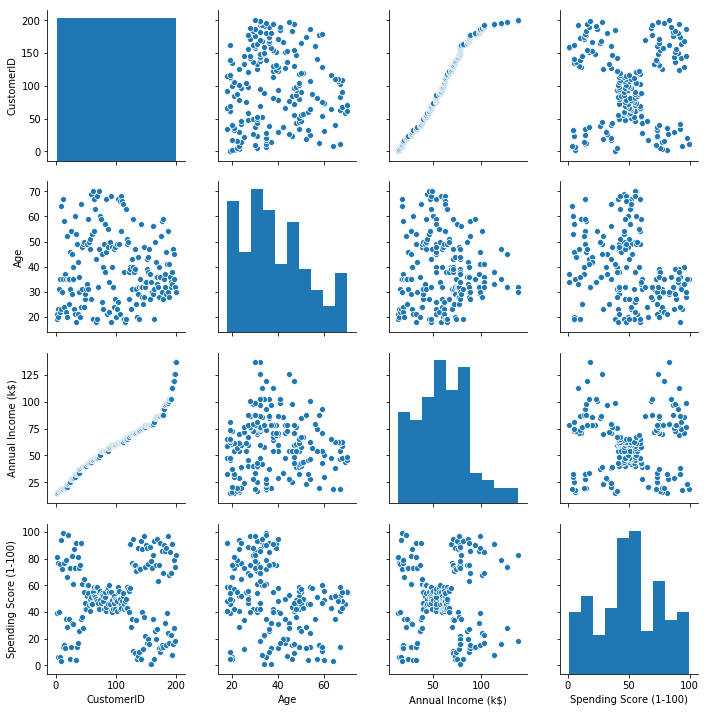

In [ ]:
num_columns= [*customers.select_dtypes(['int64', 'float64']).columns]

sns.pairplot(customers[num_columns])
plt.show()

In [ ]:
#Why is it important to look into the descriptive statistics, distribution and correlation between variables?¶
#In order to apply K-means, we need to meet the algorithm assumptions.

#K-means assumes:

#Cluster's shape: The variance of the distribution is spherical meaning that clusters have a spherical shape. In order for this to be true, all variables should be normally distributed and have the same variance.
#Clusters' Size: All clusters have the same number of observations.
#Relationship between variables: There is little or no correlation between the variables.


In [ ]:
#Variables can be said to be normally distributed.
#if the distributions were not normal, we could apply the logarithm or Box-Cox transformation.  
#Box-Cox is a family of transformations which allows us to correct non-normal distributed variables or non-equal 
#variances.

In [ ]:
#Principal Component Analysis (PCA) to discover which dimensions best maximize the variance of features involved.

In [ ]:
#First; transform the categorical variable into two binary variables

In [ ]:
customers["Male"] = customers.Genre.apply(lambda x: 0 if x == "Male" else 1)

In [ ]:
customers["Female"] = customers.Genre.apply(lambda x: 0 if x == "Female" else 1)

In [ ]:
#customer id is self determining hence not included
X = customers.iloc[:, 2:]
X.head()

,Age,Annual Income (k$),Spending Score (1-100),Male,Female
0,19,15,39,0,1
1,21,15,81,0,1
2,20,16,6,1,0
3,23,16,77,1,0
4,31,17,40,1,0


In [ ]:
# Apply PCA and fit the features selected
pca = PCA(n_components=2).fit(X)
#During the fitting process, the model learns some quantities from the data: 
#the "components" and "explained variance".

In [ ]:
print(pca.components_)

[[-1.88980385e-01  5.88604475e-01  7.86022241e-01  3.32880772e-04
  -3.32880772e-04]
 [ 1.30957602e-01  8.08400899e-01 -5.73875514e-01 -1.57927017e-03
   1.57927017e-03]]


In [ ]:
# Transform samples using the PCA fit
pca_2d = pca.transform(X)

In [ ]:
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley, color="#c7e9c0", edgecolor="#006d2c", alpha=0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color='#253494',alpha=0.5,lw=2) 
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color="#000000", ha="center", va="center")
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color="#000000", ha="center", va="center")
    plt.xlim(-.75,1)
    plt.ylim(-0.5,1)
    plt.grid(False)
    plt.xticks(np.arange(0, 1, 0.5), size=12)
    plt.yticks(np.arange(-0.75, 1, 0.5), size=12)
    plt.xlabel("Component 1", size=14)
    plt.ylabel("Component 2", size=14)
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);  

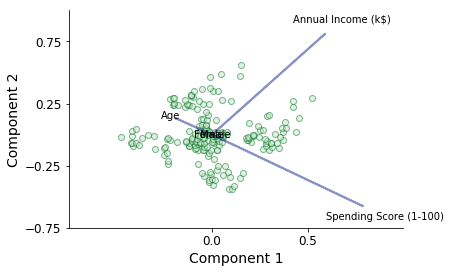

In [ ]:
#Call the function. Use only the 2 PCs.

biplot(pca_2d[:,0:2], np.transpose(pca.components_[0:2, :]), labels=X.columns)
plt.show()


In [ ]:
#We can observe that Annual Income as well as Spending Score at the two most important components.

In [ ]:
#The Elbow method looks at how the total WSS varies with the number of clusters.  
#For that, we'll compute k-means for a range of different values of k. Then, we calculate the total WSS. 
#With-in-Sum-of-Squares (WSS): WSS is the total distance of data points from their respective cluster centroids
#We plot the curve WSS vs. number of clusters.  Finally, we locate the elbow or bend of the plot. 
#This point is considered to be the appropriate number of clusters.
#One can also calculate the silhouette value which is a measure of how similar an object is to its own 
#cluster compared to other clusters

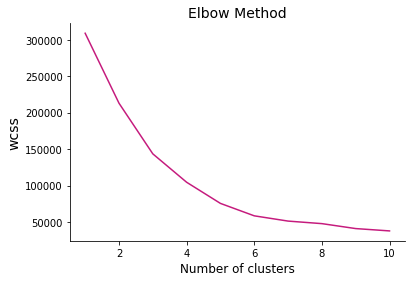

In [ ]:
wcss = []
for i in range(1,11):
    km = KMeans(n_clusters=i,init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X)
    wcss.append(km.inertia_)
plt.plot(range(1,11),wcss, c="#c51b7d")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.title('Elbow Method', size=14)
plt.xlabel('Number of clusters', size=12)
plt.ylabel('wcss', size=14)
plt.show()

In [ ]:
# Kmeans algorithm
# n_clusters: Number of clusters. In our case 5
# init: k-means++. Smart initialization
# max_iter: Maximum number of iterations of the k-means algorithm for a single run
# n_init: Number of time the k-means algorithm will be run with different centroid seeds. 
# random_state: Determines random number generation for centroid initialization.
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=10, n_init=10, random_state=0)

# Fit and predict 
y_means = kmeans.fit_predict(X)

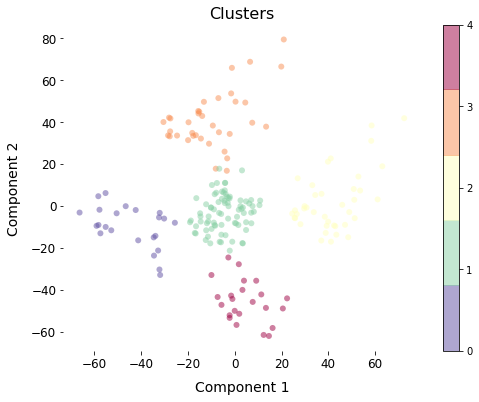

In [ ]:

#Now, let's check how our clusters look like:
fig, ax = plt.subplots(figsize = (8, 6))

plt.scatter(pca_2d[:, 0], pca_2d[:, 1],
            c=y_means, 
            edgecolor="none", 
            cmap=plt.cm.get_cmap("Spectral_r", 5),
            alpha=0.5)
        
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.xticks(size=12)
plt.yticks(size=12)

plt.xlabel("Component 1", size = 14, labelpad=10)
plt.ylabel("Component 2", size = 14, labelpad=10)

plt.title('Clusters', size=16)


plt.colorbar(ticks=[0, 1, 2, 3, 4]);

plt.show()

In [ ]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = ["Age", "Annual Income", "Spending", "Male", "Female"])

In [ ]:
centroids.index_name = "ClusterID"

In [ ]:
centroids["ClusterID"] = centroids.index
centroids = centroids.reset_index(drop=True)

In [ ]:
centroids

,Age,Annual Income,Spending,Male,Female,ClusterID
0,45.217391,26.304348,20.913043,0.608696,0.391304,0
1,43.088608,55.291139,49.569620,0.582278,0.417722,1
2,32.692308,86.538462,82.128205,0.538462,0.461538,2
3,40.666667,87.750000,17.583333,0.472222,0.527778,3
4,25.521739,26.304348,78.565217,0.608696,0.391304,4


In [ ]:
#The most important features appear to be Annual Income and Spending score.  
Segment 0 - These customers have low income and low spend 
Segment 1 - These customers have high income and spend a lot 
Segment 2 - These customers have the highest income and the highest spend  
Segment 3 - Then we have customers whose income is very high but spend the least
Segment 4 - And last, people whose earnings are little but they spend a lot

In [ ]:
#This information can then be used to predit what segments a new customer may belong to